In [2]:
%matplotlib widget  

In [3]:
%pip install ipympl


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
# Run this in its own cell BEFORE plotting
from IPython import get_ipython

def enable_notebook_interaction():
    ip = get_ipython()
    if not ip:
        print("Not running inside IPython/Jupyter.")
        return
    try:
        import ipympl  # needs: pip install ipympl
        ip.run_line_magic("matplotlib", "widget")
        print("✅ Using %matplotlib widget (ipympl). Click/drag now works.")
    except ImportError:
        ip.run_line_magic("matplotlib", "notebook")
        print("⚠️ ipympl not installed. Using %matplotlib notebook (less robust).\n"
              "Install ipympl for best results: pip install ipympl")

enable_notebook_interaction()


✅ Using %matplotlib widget (ipympl). Click/drag now works.


In [30]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
 
# =========================
# Helpers / I/O
# =========================

def load_mat_file(file_path):
    """
    Load a MATLAB file, handling both v7.3 (HDF5) and earlier formats.
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found - {file_path}")
        return None
    try:
        data = loadmat(file_path)
        print(f"Loaded non-v7.3 file: {file_path}")
        return data
    except NotImplementedError:
        try:
            with h5py.File(file_path, 'r') as f:
                print(f"Loaded v7.3 file: {file_path}")
                return {key: f[key][:] for key in f.keys() if not key.startswith('__')}
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            return None

# Debug Data

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_force_from_mat(force_mat):
    F = load_mat_file(force_mat)
    fsF = int(np.atleast_1d(F['fsamp']).squeeze())
    FC  = np.asarray(F['force_conv'], float)
    Fx, Fy = FC[0].ravel(), FC[1].ravel()
    Fab = np.sqrt(Fx**2 + Fy**2)

    tF = np.arange(Fab.size) / fsF
    plt.figure(figsize=(11,4))
    plt.plot(tF, Fab, label='Force |abs|')
    plt.plot(tF, Fx, label='Fx', alpha=0.6)
    plt.plot(tF, Fy, label='Fy', alpha=0.6)
    plt.xlabel('Time (s)'); plt.ylabel('N')
    plt.legend(); plt.title("Force channels from MAT")
    plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


In [32]:
# =========================
# EMG object->matrix converter
# =========================

def object_emg_to_matrix(obj_arr):
    """
    Convert an object/cell array of EMG channels (e.g., shape (8,2)) into a 2D float array (C, T).
    Each element is expected to be a 1D array-like time series. Channels are aligned to the shortest length.
    Returns shape (C, T), where C = number of non-empty cells.
    """
    if not isinstance(obj_arr, np.ndarray) or obj_arr.dtype != object:
        raise ValueError("object_emg_to_matrix expects a numpy object array (MATLAB cell-array-like).")

    flat = obj_arr.ravel()
    chans = []
    for elem in flat:
        arr = np.asarray(elem).squeeze()
        if arr.ndim > 1:
            arr = arr.reshape(-1)
        arr = arr.astype(float)
        arr = arr[np.isfinite(arr)]
        if arr.size > 0:
            chans.append(arr)

    if len(chans) == 0:
        return np.array([], dtype=float)

    L = min(len(c) for c in chans)
    M = np.vstack([c[:L] for c in chans])  # (C, T)
    return M


def plot_emg_from_mat(emg_mat):
    E = load_mat_file(emg_mat)
    fsE = int(np.atleast_1d(E['fsamp']).squeeze())
    EMG = np.asarray(E['SIG'])
    if EMG.dtype == object:
        EMG = object_emg_to_matrix(EMG)
    else:
        EMG = np.asarray(EMG, float)

    tE = np.arange(EMG.shape[1]) / fsE
    plt.figure(figsize=(11,4))
    for ch in range(min(8, EMG.shape[0])):  # plot up to 8 channels for clarity
        plt.plot(tE, EMG[ch], label=f'ch{ch}')
    plt.xlabel('Time (s)'); plt.ylabel('Amplitude (a.u.)')
    plt.legend(ncol=4, fontsize=8)
    plt.title("Raw EMG channels from SIG")
    plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


In [33]:
force_mat = "/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/180Deg_F1_2.mat"
emg_mat   = "/Users/juliahagen/IntMS_EEG/data/P3/180Deg_F1_2.mat"


Loaded non-v7.3 file: /Users/juliahagen/IntMS_EEG/data/P3_forces_cut/180Deg_F1_2.mat


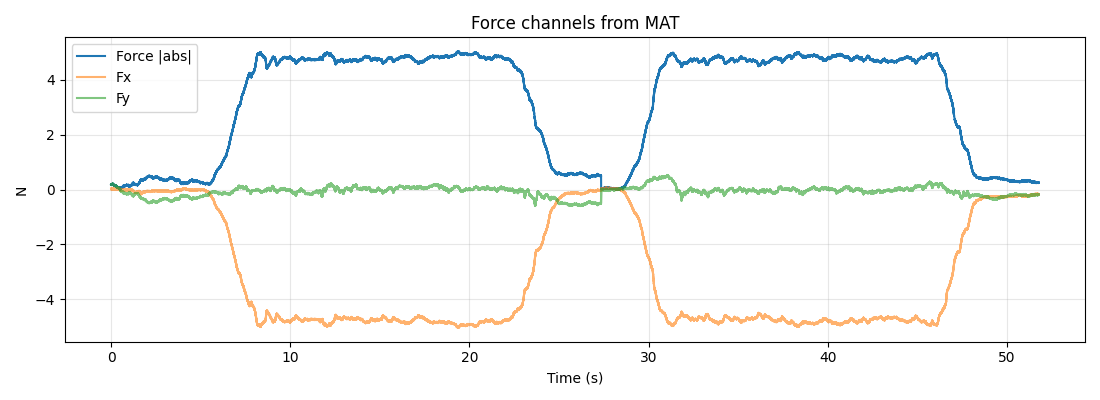

Loaded non-v7.3 file: /Users/juliahagen/IntMS_EEG/data/P3/180Deg_F1_2.mat


/var/folders/zx/p5th83xd731bwx62tvp4nwgr0000gn/T/ipykernel_41548/4086069420.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(11,4))


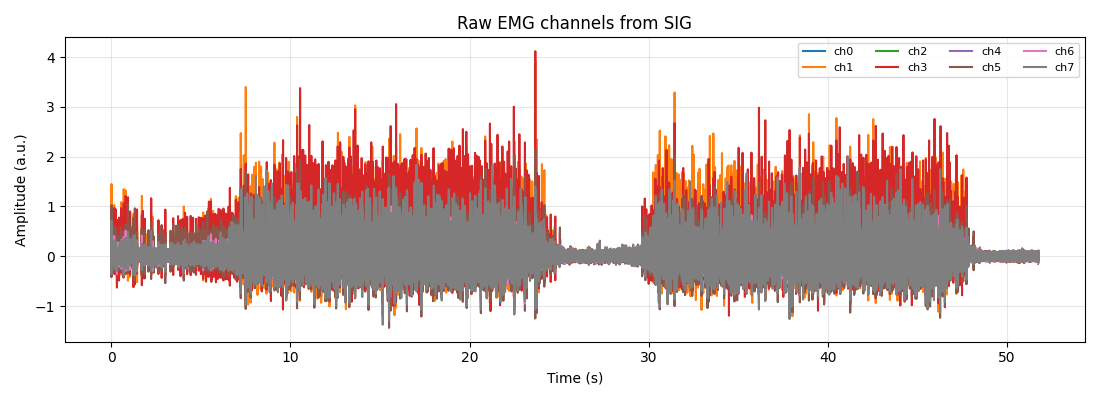

In [34]:
plot_force_from_mat(force_mat)
plot_emg_from_mat(emg_mat)


In [35]:
from scipy.io import loadmat


for path in [force_mat, emg_mat]:
    print(f"\n=== {path.split('/')[-1]} ===")
    data = loadmat(path, squeeze_me=True, struct_as_record=False)
    for key, val in data.items():
        if not key.startswith("__"):
            if hasattr(val, "shape"):
                print(f"{key:20s} shape={val.shape} dtype={getattr(val, 'dtype', type(val))}")
            else:
                print(f"{key:20s} type={type(val)} value={val}")



=== 180Deg_F1_2.mat ===
ForceAmplitude       type=<class 'float'> value=4.79
Force_Direction      type=<class 'int'> value=180
Force_N_Conversion_Factor type=<class 'float'> value=0.018
MCP_Angle            type=<class 'int'> value=180
MVC_Value            type=<class 'int'> value=1
Protocol_Series      shape=(12, 8) dtype=float64
Slope_Down           type=<class 'float'> value=1.92
Slope_Up             type=<class 'float'> value=1.92
cutsamples           shape=(3,) dtype=int32
filename             type=<class 'str'> value=P3_Julia/180Deg_F1_2_plateau_noEMG.mat
force_conv           shape=(2, 530001) dtype=float32
force_conv_abs       shape=(530001,) dtype=float32
force_raw            shape=(2, 530001) dtype=float32
force_raw_abs        shape=(530001,) dtype=float32
force_target         shape=(2, 530001) dtype=float64
force_target_abs     shape=(530001,) dtype=float64
fsamp                type=<class 'int'> value=10240
timestamps           shape=(2880,) dtype=float64

=== 180Deg_F1_2.m

Loaded non-v7.3 file: /Users/juliahagen/IntMS_EEG/data/P3_forces_cut/180Deg_F1_2.mat
Loaded non-v7.3 file: /Users/juliahagen/IntMS_EEG/data/P3/180Deg_F1_2.mat
Force: fsamp=10240 Hz | samples=530001 | duration=51.758 s
EMG  : fsamp=10240 Hz | samples=529998 | duration=51.758 s


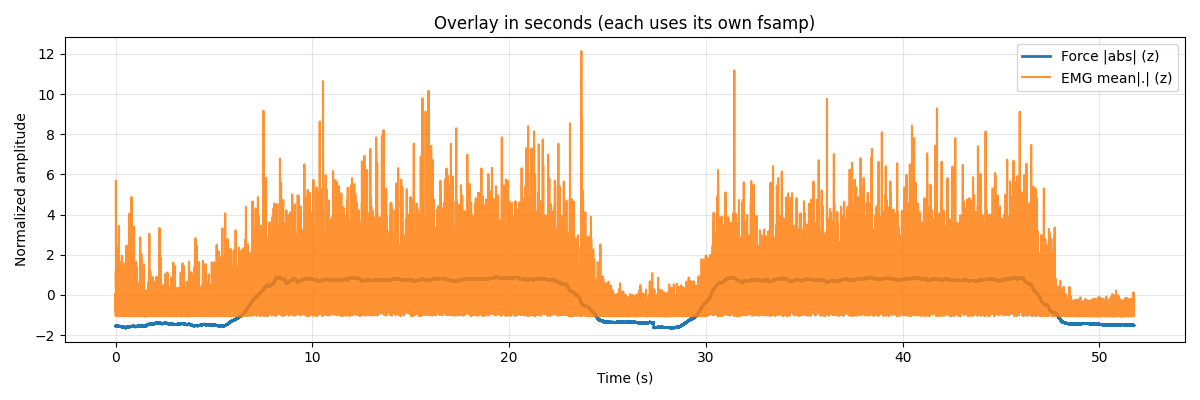

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Minimal overlay using your existing helpers: load_mat_file, object_emg_to_matrix
def overlay_force_emg(force_mat, emg_mat):
    # ---- Force ----
    F = load_mat_file(force_mat)
    fsF = int(np.atleast_1d(F['fsamp']).squeeze())   # uses fsamp -> seconds
    FC  = np.asarray(F['force_conv'], float)
    Fx, Fy = FC[0].ravel(), FC[1].ravel()
    Fab = np.sqrt(Fx**2 + Fy**2)                     # 1-D force magnitude
    tF  = np.arange(Fab.size) / fsF                  # seconds

    # ---- EMG ----
    E   = load_mat_file(emg_mat)
    fsE = int(np.atleast_1d(E['fsamp']).squeeze())   # uses fsamp -> seconds
    EMG = np.asarray(E['SIG'])
    if EMG.dtype == object:
        EMG = object_emg_to_matrix(EMG)
    else:
        EMG = np.asarray(EMG, float)
    # simple 1-D EMG summary: mean absolute across channels (fast + robust)
    emg_1d = np.mean(np.abs(EMG), axis=0)
    tE  = np.arange(emg_1d.size) / fsE               # seconds

    # ---- Print diagnostics about x-axes ----
    print(f"Force: fsamp={fsF} Hz | samples={Fab.size} | duration={Fab.size/fsF:.3f} s")
    print(f"EMG  : fsamp={fsE} Hz | samples={emg_1d.size} | duration={emg_1d.size/fsE:.3f} s")

    # ---- Normalize for visual overlay (zero-mean, unit-std) ----
    Fab_z   = (Fab - Fab.mean()) / (Fab.std() + 1e-8)
    emg_z   = (emg_1d - emg_1d.mean()) / (emg_1d.std() + 1e-8)

    # ---- Plot in SECONDS (each uses its own fsamp-derived axis) ----
    plt.figure(figsize=(12,4))
    plt.plot(tF, Fab_z, label='Force |abs| (z)', linewidth=2)
    plt.plot(tE, emg_z, label='EMG mean|.| (z)', alpha=0.85)
    plt.title("Overlay in seconds (each uses its own fsamp)")
    plt.xlabel("Time (s)"); plt.ylabel("Normalized amplitude")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 👉 Run:
overlay_force_emg(force_mat, emg_mat)

## P3: Aligning EMG & Forces 

Force: fsamp=10240 Hz | samples=530001 | duration=51.758 s
EMG  : fsamp=10240 Hz | samples=1059996 | duration=103.515 s
ref  : samples=529998 (valid=529998) | duration≈51.758 s
t_common: N=529997 | min_dur=51.758 s | dt=0.000098 s


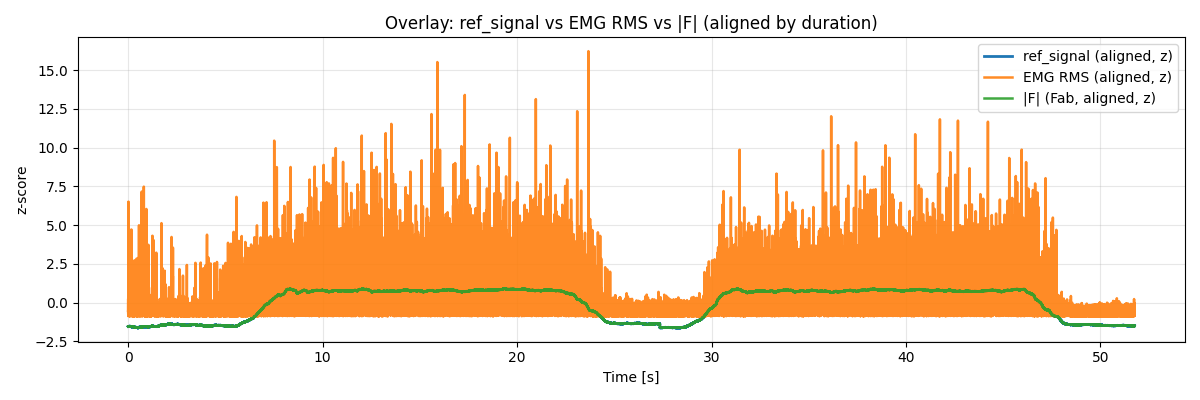

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# ------------------------------------------------------------------
# Set these two paths before running:
# force_mat = "/path/to/force.mat"
# emg_mat   = "/path/to/emg.mat"
# ------------------------------------------------------------------

# ---------------- helpers ----------------
def load_mat(path):
    # squeeze structs/cells for easier access
    return loadmat(path, squeeze_me=True, struct_as_record=False)

def get_fs(d):
    return int(np.atleast_1d(d["fsamp"]).squeeze())

def extract_force(F):
    FC = np.asarray(F["force_conv"], float)
    if FC.ndim != 2:
        raise ValueError(f"'force_conv' must be 2D, got {FC.shape}")
    if FC.shape[0] != 2 and FC.shape[1] == 2:
        FC = FC.T
    Fx, Fy = FC[0].ravel(), FC[1].ravel()
    Fab = np.sqrt(Fx**2 + Fy**2)
    return Fx, Fy, Fab

def object_emg_to_matrix(SIG):
    SIG = np.asarray(SIG, dtype=object)
    if SIG.ndim == 1:
        SIG = SIG.reshape(-1, 1)
    per_ch, max_len = [], 0
    for r in range(SIG.shape[0]):
        parts = []
        for c in range(SIG.shape[1]):
            cell = SIG[r, c]
            if cell is None: 
                continue
            a = np.asarray(cell).squeeze()
            if a.ndim == 0 or a.size == 0:
                continue
            if a.ndim > 1:
                a = a.reshape(-1)
            parts.append(a.astype(float))
        ch = np.concatenate(parts, axis=0) if parts else np.array([], dtype=float)
        per_ch.append(ch)
        max_len = max(max_len, ch.size)
    M = np.full((len(per_ch), max_len), np.nan, dtype=float)
    for i, ch in enumerate(per_ch):
        if ch.size:
            M[i, :ch.size] = ch
    return M

def extract_emg(E):
    SIG = E.get("SIG", None)
    if SIG is None:
        raise ValueError("EMG 'SIG' not found")
    SIG = np.asarray(SIG)
    if SIG.dtype == object:
        EMG = object_emg_to_matrix(SIG)  # (channels, samples)
    else:
        EMG = np.asarray(SIG, float)
        if EMG.ndim == 1:
            EMG = EMG[np.newaxis, :]
    return EMG

def extract_ref(E):
    """Return 1D ref_signal; if cell/object, concatenate pieces."""
    ref = E.get("ref_signal", None) if hasattr(E, "get") else (E["ref_signal"] if "ref_signal" in E else None)
    if ref is None:
        return None
    ref = np.asarray(ref)
    if ref.dtype == object:
        parts = []
        for cell in ref.ravel():
            if cell is None: 
                continue
            a = np.asarray(cell).squeeze()
            if a.ndim == 0 or a.size == 0:
                continue
            if a.ndim > 1:
                a = a.reshape(-1)
            parts.append(a.astype(float))
        if not parts:
            return None
        return np.concatenate(parts, axis=0)
    return np.asarray(ref, float).ravel()

def z_nan_safe(x):
    x = np.asarray(x, float).ravel()
    m = np.nanmean(x); s = np.nanstd(x)
    if not np.isfinite(m): m = 0.0
    if not np.isfinite(s) or s == 0: s = 1.0
    return (x - m) / s

def fill_nans(a):
    a = np.asarray(a, float).ravel()
    if np.all(~np.isfinite(a)): 
        return np.zeros_like(a)
    m = np.nanmean(a)
    return np.nan_to_num(a, nan=m, posinf=m, neginf=m)

# ---------------- load both files ----------------
F = load_mat(force_mat)
E = load_mat(emg_mat)

fsF, fsE = get_fs(F), get_fs(E)
Fx, Fy, Fab = extract_force(F)
EMG = extract_emg(E)                # (channels, samples)
ref = extract_ref(E)                # 1D or None

# time axes from lengths (we only care about duration)
tF = np.arange(Fx.size) / fsF
tE = np.arange(EMG.shape[1]) / fsE
durF, durE = tF[-1], tE[-1]

# ref duration from its own length (if present), assume same fs as EMG
if ref is not None:
    # allow NaNs in ref: build time only for valid samples
    ref = np.asarray(ref, float).ravel()
    valid_idx = np.nonzero(np.isfinite(ref))[0]
    if valid_idx.size > 0:
        durRef = valid_idx[-1] / float(fsE)
    else:
        durRef = 0.0
else:
    durRef = np.inf  # effectively ignore in min()

# common grid over the minimum duration, at the higher sampling rate
min_dur = min(durF, durE, durRef)
dt = 1.0 / max(fsF, fsE)
t_common = np.arange(0.0, min_dur, dt)

# interpolate to t_common
Fab_al = np.interp(t_common, tF, Fab)
EMG_al = np.vstack([np.interp(t_common, tE, EMG[ch]) for ch in range(EMG.shape[0])])

if ref is not None and valid_idx.size > 0:
    # build ref time base only for valid samples, then interpolate
    t_ref = valid_idx / float(fsE)
    ref_valid = ref[valid_idx]
    ref_al = np.interp(t_common, t_ref, ref_valid, left=ref_valid[0], right=ref_valid[-1])
else:
    # fallback if ref missing/all-NaN: mean|EMG|
    ref_al = np.mean(np.abs(EMG_al), axis=0)

# EMG RMS across channels
emg_rms_al = np.sqrt(np.nanmean(EMG_al**2, axis=0))

# NaN-safe before plotting
Fab_al     = fill_nans(Fab_al)
ref_al     = fill_nans(ref_al)
emg_rms_al = fill_nans(emg_rms_al)

# diagnostics
print(f"Force: fsamp={fsF} Hz | samples={Fx.size} | duration={durF:.3f} s")
print(f"EMG  : fsamp={fsE} Hz | samples={EMG.shape[1]} | duration={durE:.3f} s")
if ref is not None:
    print(f"ref  : samples={ref.size} (valid={valid_idx.size}) | duration≈{(valid_idx[-1]/fsE if valid_idx.size else 0):.3f} s")
print(f"t_common: N={t_common.size} | min_dur={min_dur:.3f} s | dt={dt:.6f} s")

# ---------------- plot overlay ----------------
plt.figure(figsize=(12, 4))
plt.plot(t_common, z_nan_safe(ref_al),     label="ref_signal (aligned, z)", lw=2.0)
plt.plot(t_common, z_nan_safe(emg_rms_al), label="EMG RMS (aligned, z)",    lw=1.8, alpha=0.9)
plt.plot(t_common, z_nan_safe(Fab_al),     label="|F| (Fab, aligned, z)",   lw=1.8, alpha=0.9)
plt.xlabel("Time [s]")
plt.ylabel("z-score")
plt.title("Overlay: ref_signal vs EMG RMS vs |F| (aligned by duration)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Lengths equal to t_common? True | N = 529997
All-finite counts: ref: 529997 RMS: 529997 Fab: 529997
corr(ref, RMS) = 0.349581
corr(ref, Fab) = 0.999996
corr(RMS, Fab) = 0.349581
allclose(ref, RMS)? False


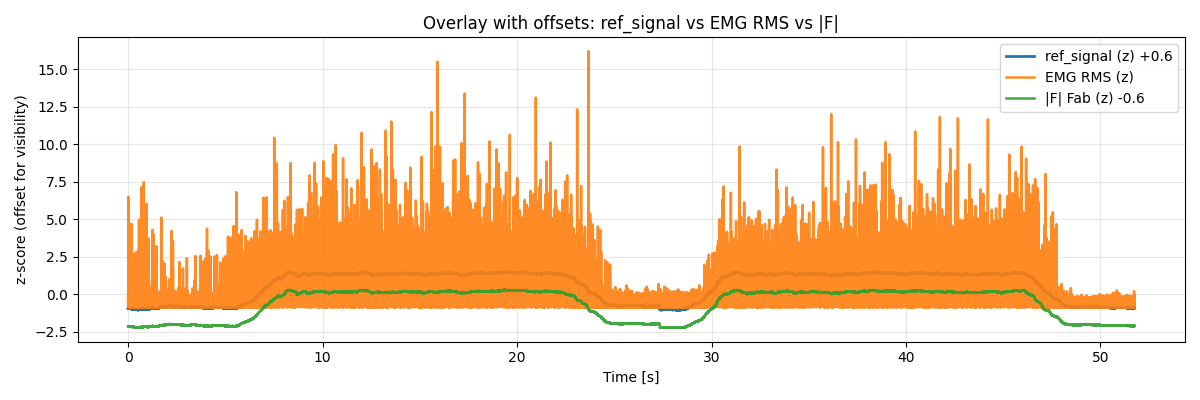

In [38]:
# assumes you already built: t_common, EMG_al, Fab_al, ref_al  (from the last cell)

import numpy as np
import matplotlib.pyplot as plt

def z(x):
    x = np.asarray(x, float).ravel()
    m = np.nanmean(x); s = np.nanstd(x)
    if not np.isfinite(s) or s == 0: s = 1.0
    return (x - m) / s

# Compute RMS across channels for the aligned EMG
emg_rms_al = np.sqrt(np.nanmean(EMG_al**2, axis=0))

# Make them finite for stats/plot
def finite(a):
    a = np.asarray(a, float).ravel()
    if np.all(~np.isfinite(a)): return np.zeros_like(a)
    m = np.nanmean(a)
    return np.nan_to_num(a, nan=m, posinf=m, neginf=m)

Fab_f     = finite(Fab_al)
ref_f     = finite(ref_al)
rms_f     = finite(emg_rms_al)

# --- Diagnostics ---
same_len = (t_common.size == ref_f.size == rms_f.size == Fab_f.size)
print(f"Lengths equal to t_common? {same_len} | N = {t_common.size}")
print("All-finite counts: ref:", np.isfinite(ref_f).sum(),
      "RMS:", np.isfinite(rms_f).sum(), "Fab:", np.isfinite(Fab_f).sum())

# correlation & equality checks
def corr(a,b):
    a = z(a); b = z(b)
    return float(np.nan_to_num(np.corrcoef(a, b)[0,1]))

r_ref_rms  = corr(ref_f, rms_f)
r_ref_fab  = corr(ref_f, Fab_f)
r_rms_fab  = corr(rms_f, Fab_f)

print(f"corr(ref, RMS) = {r_ref_rms:.6f}")
print(f"corr(ref, Fab) = {r_ref_fab:.6f}")
print(f"corr(RMS, Fab) = {r_rms_fab:.6f}")
print("allclose(ref, RMS)?", np.allclose(ref_f, rms_f, rtol=1e-6, atol=1e-8))

# --- Plot with slight vertical offsets so lines don't hide each other ---
ref_z  = z(ref_f)
rms_z  = z(rms_f)
fab_z  = z(Fab_f)

offset = 0.6  # visual separation only
plt.figure(figsize=(12,4))
plt.plot(t_common, ref_z + offset, label="ref_signal (z) +0.6", linewidth=2.0)
plt.plot(t_common, rms_z,           label="EMG RMS (z)",        linewidth=1.8, alpha=0.9)
plt.plot(t_common, fab_z - offset,  label="|F| Fab (z) -0.6",   linewidth=1.8, alpha=0.9)
plt.xlabel("Time [s]"); plt.ylabel("z-score (offset for visibility)")
plt.title("Overlay with offsets: ref_signal vs EMG RMS vs |F|")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


Need to be debugged:   ("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/135Deg_F2_2.mat",
     "/Users/juliahagen/IntMS_EEG/data/P3/135Deg_F2_2.mat"),
        ("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/135Deg_F2_1.mat",
    "/Users/juliahagen/IntMS_EEG/data/P3/135Deg_F2_1.mat"),
     ("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/90Deg_F2_2.mat",
     "/Users/juliahagen/IntMS_EEG/data/P3/90Deg_F2_2.mat"),
    ("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/180Deg_F2_2.mat",
     "/Users/juliahagen/IntMS_EEG/data/P3/180Deg_F2_2.mat"),
     

In [41]:
import numpy as np
from scipy.io import loadmat
from pathlib import Path


# ===================== CONFIG =====================
pairs = [("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/90Deg_F2_2.mat","/Users/juliahagen/IntMS_EEG/data/P3/90Deg_F2_2.mat"),
  ("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/135Deg_F2_1.mat","/Users/juliahagen/IntMS_EEG/data/P3/135Deg_F2_1.mat"),
  ("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/135Deg_F2_2.mat","/Users/juliahagen/IntMS_EEG/data/P3/135Deg_F2_2.mat"),
  ("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/180Deg_F2_2.mat", "/Users/juliahagen/IntMS_EEG/data/P3/180Deg_F2_2.mat")]
#("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/90Deg_F1_1.mat",
#"/Users/juliahagen/IntMS_EEG/data/P3/90Deg_F1_1.mat"),

#("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/90Deg_F1_2.mat",
#"/Users/juliahagen/IntMS_EEG/data/P3/90Deg_F1_2.mat"),

#("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/90Deg_F2_1.mat",
#"/Users/juliahagen/IntMS_EEG/data/P3/90Deg_F2_1.mat"),

#("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/135Deg_F1_1.mat",
#"/Users/juliahagen/IntMS_EEG/data/P3/135Deg_F1_1.mat"),

#("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/135Deg_F1_2.mat",
#"/Users/juliahagen/IntMS_EEG/data/P3/135Deg_F1_2.mat"),

#("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/180Deg_F1_2.mat",
#"/Users/juliahagen/IntMS_EEG/data/P3/180Deg_F1_2.mat"),

#("/Users/juliahagen/IntMS_EEG/data/P3_forces_cut/180Deg_F2_1.mat",
#"/Users/juliahagen/IntMS_EEG/data/P3/180Deg_F2_1.mat"),

#pairs = [
## ("/Users/juliahagen/IntMS_EEG/data/P5_forces_cut/90Deg_F1_1.mat",
##  "/Users/juliahagen/IntMS_EEG/data/P5/90Deg_F1_1.mat"),

## ("/Users/juliahagen/IntMS_EEG/data/P5_forces_cut/90Deg_F2_1.mat",
##  "/Users/juliahagen/IntMS_EEG/data/P5/90Deg_F2_1.mat"),

## ("/Users/juliahagen/IntMS_EEG/data/P5_forces_cut/135Deg_F1_1.mat",
##  "/Users/juliahagen/IntMS_EEG/data/P5/135Deg_F1_1.mat"),

## ("/Users/juliahagen/IntMS_EEG/data/P5_forces_cut/135Deg_F2_1.mat",
##  "/Users/juliahagen/IntMS_EEG/data/P5/135Deg_F2_1.mat"),

## ("/Users/juliahagen/IntMS_EEG/data/P5_forces_cut/180Deg_F1_1.mat",
##  "/Users/juliahagen/IntMS_EEG/data/P5/180Deg_F1_1.mat"),

## ("/Users/juliahagen/IntMS_EEG/data/P5_forces_cut/180Deg_F2_1.mat",
##  "/Users/juliahagen/IntMS_EEG/data/P5/180Deg_F2_1.mat"),
#]
 
out_dir = Path(".")           # where to save *_combined.npy
tolerance_sec = 0.05          # only used for a warning print



In [44]:
from pathlib import Path
import numpy as np
from scipy.io import loadmat

# ---------- config ----------
out_dir = Path(".")
tolerance_sec = 0.05

# ================ helper functions ================
import h5py
from scipy.io import loadmat
import numpy as np

def _to_numpy(dset: h5py.Dataset):
    arr = dset[()]  # read
    try:
        if getattr(dset, "dtype", None) and dset.dtype.kind in ("S", "O", "U"):
            return np.array(arr).astype(str)
    except Exception:
        pass
    return np.array(arr).squeeze()

def _h5_to_obj(h5obj):
    """Recursively convert HDF5 groups/datasets to Python structures."""
    if isinstance(h5obj, h5py.Dataset):
        dset = h5obj
        # Handle cell arrays / object references
        if dset.dtype == h5py.ref_dtype:
            refs = dset[()]
            f = dset.file

            def deref(r):
                # r is an h5py.Reference or null; guard nulls
                if r is None or (hasattr(r, "__bool__") and not r):
                    return None
                return _h5_to_obj(f[r])

            if refs.shape == ():  # scalar ref
                return deref(refs)
            out = np.empty(refs.shape, dtype=object)
            for idx in np.ndindex(refs.shape):
                out[idx] = deref(refs[idx])
            return np.squeeze(out)
        # Regular numeric/string dataset
        return _to_numpy(dset)

    if isinstance(h5obj, h5py.Group):
        out = {}
        for k, v in h5obj.items():
            out[k] = _h5_to_obj(v)
        return out

    # Fallback (shouldn't hit)
    return h5obj

def _is_mat73(path: str) -> bool:
    try:
        with h5py.File(path, "r"):
            return True
    except Exception:
        return False

def _load_mat_any(path: str) -> dict:
    # Try classic MAT first
    try:
        data = loadmat(path, struct_as_record=False, squeeze_me=True)
        data = {k: v for k, v in data.items() if not k.startswith("__")}
        return data
    except Exception as e:
        if "7.3" not in str(e) and "HDF5" not in str(e):
            # Real error unrelated to 7.3 — surface it
            raise

    # v7.3
    if not _is_mat73(path):
        raise RuntimeError(f"Unsupported or unreadable MAT file (not v5/v7 nor v7.3): {path}")
    with h5py.File(path, "r") as f:
        data = _h5_to_obj(f)

    # Optional: unwrap single top-level struct
    if isinstance(data, dict) and len(data) == 1:
        only = next(iter(data.values()))
        if isinstance(only, dict):
            data = only
    return data

def _loadmat(path: str) -> dict:
    d = _load_mat_any(path)
    if d is None or not isinstance(d, dict):
        raise RuntimeError(f"Could not load MAT file into a dict: {path}")
    return d


def _get_fs(d):
    return int(np.atleast_1d(d["fsamp"]).squeeze())

def _extract_force(F):
    FC = np.asarray(F["force_conv"], float)
    if FC.ndim != 2:
        raise ValueError(f"'force_conv' must be 2D, got {FC.shape}")
    if FC.shape[0] != 2 and FC.shape[1] == 2:
        FC = FC.T
    Fx, Fy = FC[0].ravel(), FC[1].ravel()
    Fab = np.sqrt(Fx**2 + Fy**2)
    return Fx, Fy, Fab

def _object_emg_to_matrix(SIG):
    SIG = np.asarray(SIG, dtype=object)
    if SIG.ndim == 1:
        SIG = SIG.reshape(-1, 1)
    channels, max_len = [], 0
    R, C = SIG.shape
    for r in range(R):
        for c in range(C):
            cell = SIG[r, c]
            if cell is None:
                vec = np.array([], dtype=float)
            else:
                vec = np.asarray(cell).squeeze()
                if vec.ndim == 0 or vec.size == 0:
                    vec = np.array([], dtype=float)
                elif vec.ndim > 1:
                    vec = vec.reshape(-1)
                vec = vec.astype(float)
            channels.append(vec)
            max_len = max(max_len, vec.size)
    M = np.full((len(channels), max_len), np.nan, dtype=float)
    for i, vec in enumerate(channels):
        if vec.size:
            M[i, :vec.size] = vec
    return M  # (rows*cols, max_len)

def _extract_emg(E):
    SIG = E.get("SIG", None)
    if SIG is None:
        raise ValueError("EMG 'SIG' not found in EMG .mat")
    SIG = np.asarray(SIG)
    if SIG.dtype == object:
        EMG = _object_emg_to_matrix(SIG)     # stack columns as channels
    else:
        EMG = np.asarray(SIG, float)
        if EMG.ndim == 1:
            EMG = EMG[np.newaxis, :]
    return EMG  # (channels, samples)

def _extract_ref(E):
    ref = E.get("ref_signal", None) if hasattr(E, "get") else (E["ref_signal"] if "ref_signal" in E else None)
    if ref is None:
        return None
    ref = np.asarray(ref)
    if ref.dtype == object:
        parts = []
        for cell in ref.ravel():
            if cell is None:
                continue
            a = np.asarray(cell).squeeze()
            if a.ndim == 0 or a.size == 0:
                continue
            if a.ndim > 1:
                a = a.reshape(-1)
            parts.append(a.astype(float))
        if not parts:
            return None
        return np.concatenate(parts, axis=0)
    return np.asarray(ref, float).ravel()

def _prefix_from_force_path(force_path):
    base = Path(force_path).stem.split("_")
    return "_".join(base[:3]) if len(base) >= 3 else base[0]

def _align_rows_to_common(A, t_src, t_common):
    A = np.asarray(A)
    if A.ndim == 1:
        return np.interp(t_common, t_src, A)
    elif A.ndim == 2:
        return np.vstack([np.interp(t_common, t_src, A[i]) for i in range(A.shape[0])])
    else:
        raise ValueError(f"Can't align array with ndim={A.ndim}")

# ==================== main loop ====================
out_dir.mkdir(parents=True, exist_ok=True)
ok, fail = 0, 0

for force_mat, emg_mat in pairs:
    try:
        F = _loadmat(force_mat)
        E = _loadmat(emg_mat)

        fsF, fsE = _get_fs(F), _get_fs(E)
        Fx, Fy, Fab = _extract_force(F)
        EMG = _extract_emg(E)                # (channels, samples)
        ref = _extract_ref(E)                # 1D or None

        # time axes (align by duration)
        tF = np.arange(Fx.size) / fsF
        tE = np.arange(EMG.shape[1]) / fsE
        durF, durE = tF[-1], tE[-1]

        # ref duration on EMG clock (finite samples only)
        if ref is not None:
            ref = np.asarray(ref, float).ravel()
            valid_idx = np.nonzero(np.isfinite(ref))[0]
            durRef = valid_idx[-1] / float(fsE) if valid_idx.size else 0.0
        else:
            durRef = np.inf  # ignore in min()

        if abs(durF - durE) > tolerance_sec:
            print(f"[WARN] {Path(force_mat).name}: durations differ by {abs(durF - durE):.3f}s "
                  f"(Force {durF:.3f}s vs EMG {durE:.3f}s)")

        # common time grid
        min_dur = min(durF, durE, durRef)
        dt = 1.0 / max(fsF, fsE)
        t_common = np.arange(0.0, min_dur, dt)

        # align core signals
        Fx_al  = np.interp(t_common, tF, Fx)
        Fy_al  = np.interp(t_common, tF, Fy)
        Fab_al = np.interp(t_common, tF, Fab)
        EMG_al = np.vstack([np.interp(t_common, tE, EMG[ch]) for ch in range(EMG.shape[0])])

        if ref is not None and (valid_idx := np.nonzero(np.isfinite(ref))[0]).size:
            t_ref = valid_idx / float(fsE)
            ref_valid = ref[valid_idx]
            ref_al = np.interp(t_common, t_ref, ref_valid, left=ref_valid[0], right=ref_valid[-1])
            ref_source = "from_emg_mat"
        else:
            ref_al = np.mean(np.abs(EMG_al), axis=0)
            ref_source = "computed_mean_abs_emg"

        # ALIGN EXTRA SERIES + COPY EVERYTHING ELSE (INSIDE THE LOOP!)
        force_series_names = [
            "force_conv",
            "force_conv_abs",
            "force_raw",
            "force_raw_abs",
            "force_target",
            "force_target_abs",
        ]
        force_aligned = {}
        for name in force_series_names:
            if name in F:
                try:
                    force_aligned[name] = _align_rows_to_common(F[name], tF, t_common).astype(float)
                except Exception:
                    force_aligned[name] = F[name]

        emg_aligned_extras = {}
        if "IPTs" in E:
            try:
                emg_aligned_extras["IPTs"] = _align_rows_to_common(E["IPTs"], tE, t_common).astype(float)
            except Exception:
                emg_aligned_extras["IPTs"] = E["IPTs"]

        force_info = {}
        for k, v in F.items():
            if k.startswith("__") or k in force_series_names or k == "fsamp":
                continue
            force_info[k] = v

        emg_info = {}
        for k, v in E.items():
            if k.startswith("__") or k in ("SIG", "IPTs", "fsamp", "ref_signal"):
                continue
            emg_info[k] = v

        MCP_Angle_val = int(np.atleast_1d(F["MCP_Angle"]).squeeze()) if "MCP_Angle" in F else None
        Force_Direction_val = int(np.atleast_1d(F["Force_Direction"]).squeeze()) if "Force_Direction" in F else None
        force_target_al      = force_aligned.get("force_target", None)
        force_target_abs_al  = force_aligned.get("force_target_abs", None)

        payload = {
            "time_s": t_common.astype(float),
            "Fx": Fx_al.astype(float),
            "Fy": Fy_al.astype(float),
            "Fab": Fab_al.astype(float),
            "force_target": force_target_al,
            "force_target_abs": force_target_abs_al,
            "MCP_Angle": MCP_Angle_val,
            "Force_Direction": Force_Direction_val,
            "force_aligned": force_aligned,
            "EMG": EMG_al.astype(float),
            "emg_aligned_extras": emg_aligned_extras,
            "ref_signal": ref_al.astype(float),
            "force_info": force_info,
            "emg_info": emg_info,
            "meta": {
                "fs_force": int(fsF),
                "fs_emg": int(fsE),
                "duration_force_s_raw": float(durF),
                "duration_emg_s_raw": float(durE),
                "duration_aligned_s": float(t_common[-1]) if len(t_common) else 0.0,
                "n_aligned_samples": int(len(t_common)),
                "force_file": str(force_mat),
                "emg_file": str(emg_mat),
                "emg_channels": int(EMG.shape[0]),
                "ref_source": ref_source,
            }
        }

        prefix = _prefix_from_force_path(force_mat)
        out_path = out_dir / f"{prefix}_combined.npy"
        np.save(out_path, payload, allow_pickle=True)

        print(f"✅ Saved: {out_path.name} | EMG shape: {EMG_al.shape} | N={payload['meta']['n_aligned_samples']}")
        ok += 1

    except Exception as e:
        print(f"❌ Failed on pair:\n  force={force_mat}\n  emg  ={emg_mat}\n  error={e}")
        fail += 1

print(f"\nDone. Pairs processed: {ok} ok, {fail} failed.")


[WARN] 90Deg_F2_2.mat: durations differ by 35.547s (Force 64.453s vs EMG 100.000s)
✅ Saved: 90Deg_F2_2_combined.npy | EMG shape: (16, 660000) | N=660000
✅ Saved: 135Deg_F2_1_combined.npy | EMG shape: (16, 1004159) | N=1004159
✅ Saved: 135Deg_F2_2_combined.npy | EMG shape: (16, 1004159) | N=1004159
[WARN] 180Deg_F2_2.mat: durations differ by 32.109s (Force 64.453s vs EMG 96.562s)
✅ Saved: 180Deg_F2_2_combined.npy | EMG shape: (16, 660000) | N=660000

Done. Pairs processed: 4 ok, 0 failed.



File: 135Deg_F1_1_combined.npy
  n samples: 529997
  fs_force: 10240 Hz | fs_emg: 10240 Hz
  duration_aligned_s (meta): 51.757421875000006
  ref_source: from_emg_mat
  finite counts -> ref:529997  rms:529997  Fab:529997
  corr(ref, RMS)=0.4587  corr(ref, Fab)=1.0000  corr(RMS, Fab)=0.4587


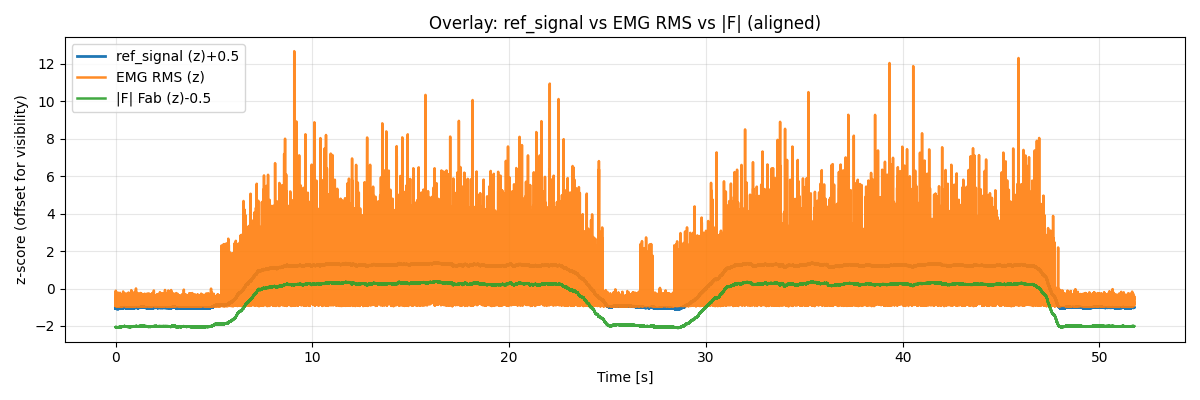


File: 135Deg_F1_2_combined.npy
  n samples: 529997
  fs_force: 10240 Hz | fs_emg: 10240 Hz
  duration_aligned_s (meta): 51.757421875000006
  ref_source: from_emg_mat
  finite counts -> ref:529997  rms:529997  Fab:529997
  corr(ref, RMS)=0.3943  corr(ref, Fab)=1.0000  corr(RMS, Fab)=0.3943


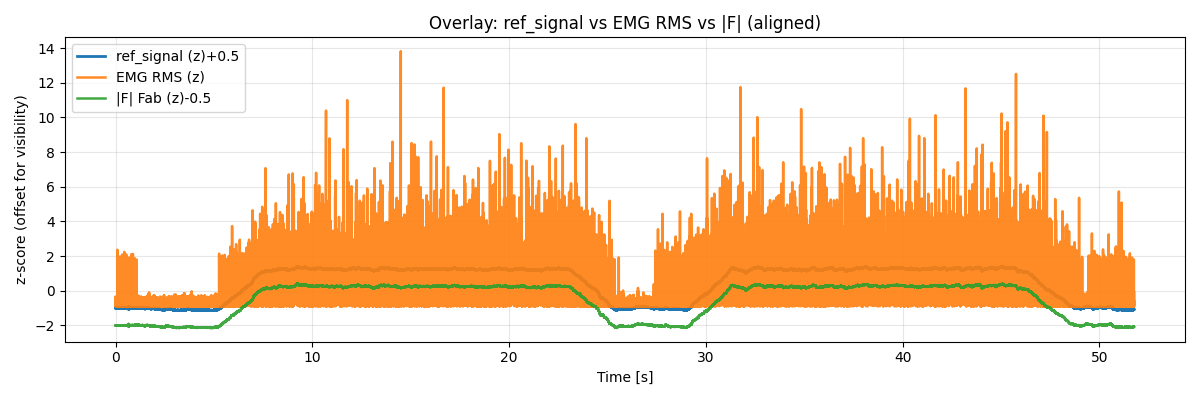


File: 180Deg_F1_2_combined.npy
  n samples: 529997
  fs_force: 10240 Hz | fs_emg: 10240 Hz
  duration_aligned_s (meta): 51.757421875000006
  ref_source: from_emg_mat
  finite counts -> ref:529997  rms:529997  Fab:529997
  corr(ref, RMS)=0.4460  corr(ref, Fab)=1.0000  corr(RMS, Fab)=0.4460


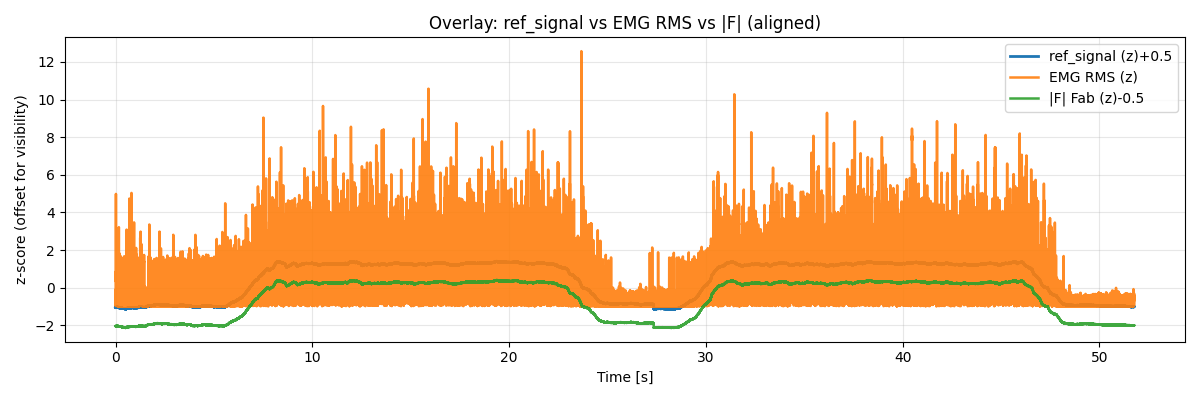


File: 180Deg_F2_1_combined.npy
  n samples: 659997
  fs_force: 10240 Hz | fs_emg: 10240 Hz
  duration_aligned_s (meta): 64.452734375
  ref_source: from_emg_mat
  finite counts -> ref:659997  rms:659997  Fab:659997
  corr(ref, RMS)=0.5936  corr(ref, Fab)=1.0000  corr(RMS, Fab)=0.5936


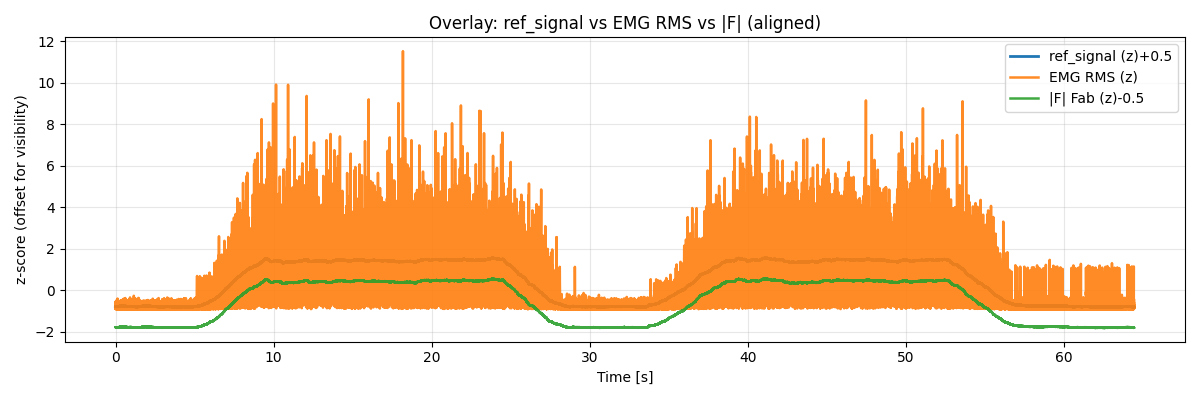


File: 90Deg_F1_1_combined.npy
  n samples: 529997
  fs_force: 10240 Hz | fs_emg: 10240 Hz
  duration_aligned_s (meta): 51.757421875000006
  ref_source: from_emg_mat
  finite counts -> ref:529997  rms:529997  Fab:529997
  corr(ref, RMS)=0.4108  corr(ref, Fab)=1.0000  corr(RMS, Fab)=0.4108


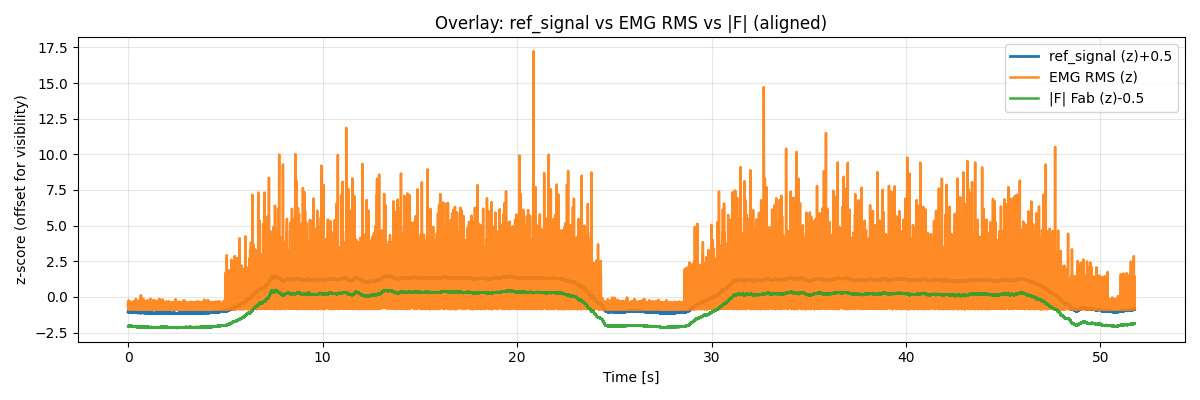


File: 90Deg_F1_2_combined.npy
  n samples: 529997
  fs_force: 10240 Hz | fs_emg: 10240 Hz
  duration_aligned_s (meta): 51.757421875000006
  ref_source: from_emg_mat
  finite counts -> ref:529997  rms:529997  Fab:529997
  corr(ref, RMS)=0.4135  corr(ref, Fab)=1.0000  corr(RMS, Fab)=0.4135


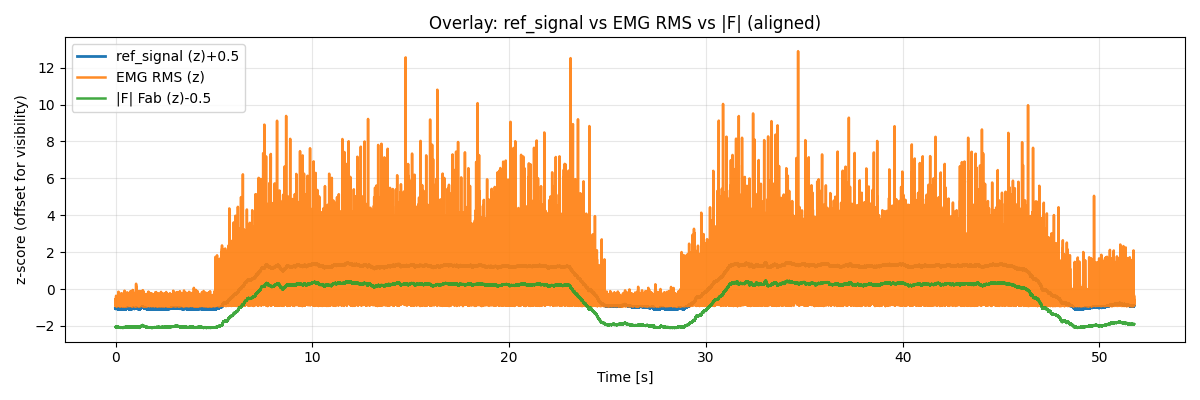


File: 90Deg_F2_1_combined.npy
  n samples: 659997
  fs_force: 10240 Hz | fs_emg: 10240 Hz
  duration_aligned_s (meta): 64.452734375
  ref_source: from_emg_mat
  finite counts -> ref:659997  rms:659997  Fab:659997
  corr(ref, RMS)=0.5216  corr(ref, Fab)=1.0000  corr(RMS, Fab)=0.5216


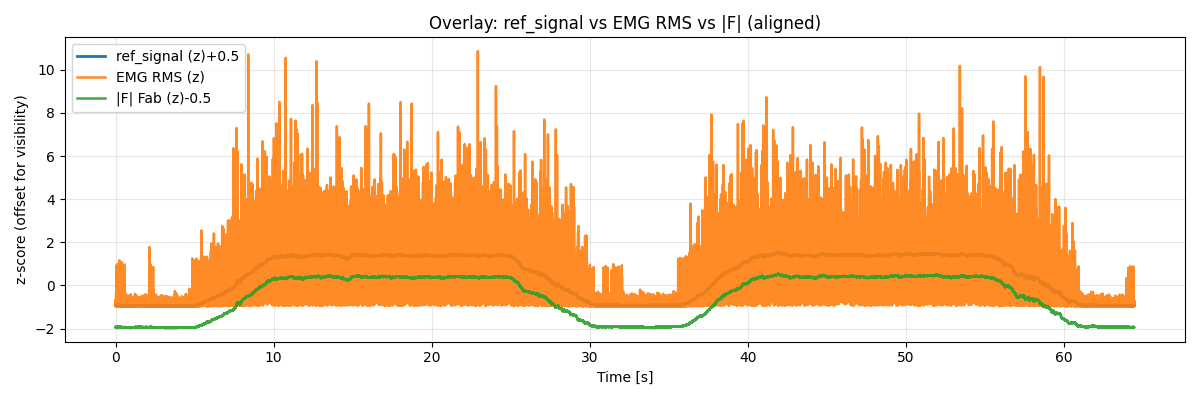

In [89]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt

def _nz(x):
    """NaN/Inf-safe normalization (z-score)."""
    x = np.asarray(x, float).ravel()
    m = np.nanmean(x); s = np.nanstd(x)
    if not np.isfinite(s) or s == 0: s = 1.0
    return (x - (m if np.isfinite(m) else 0.0)) / s

def _finite(a):
    a = np.asarray(a, float).ravel()
    if np.all(~np.isfinite(a)):  # all NaN/Inf
        return np.zeros_like(a)
    m = np.nanmean(a)
    return np.nan_to_num(a, nan=m, posinf=m, neginf=m)

def check_and_plot_combined(path, offset=0.5, show_offsets=False):
    """Load a *_combined.npy and plot ref_signal, EMG RMS, and Fab overlay."""
    data = np.load(path, allow_pickle=True).item()

    t   = np.asarray(data["time_s"], float).ravel()
    Fab = _finite(data["Fab"])
    EMG = np.asarray(data["EMG"], float)          # (channels, samples)
    ref = _finite(data.get("ref_signal", np.mean(np.abs(EMG), axis=0)))

    # Sanity: trim to same length if needed (shouldn't be necessary, but safe)
    n = min(t.size, Fab.size, ref.size, EMG.shape[1])
    if n != t.size or n != Fab.size or n != ref.size or n != EMG.shape[1]:
        t, Fab, ref, EMG = t[:n], Fab[:n], ref[:n], EMG[:, :n]

    # Derived: EMG RMS across channels
    emg_rms = _finite(np.sqrt(np.nanmean(EMG**2, axis=0)))

    # Diagnostics
    meta = data.get("meta", {})
    print(f"\nFile: {os.path.basename(path)}")
    print(f"  n samples: {n}")
    print(f"  fs_force: {meta.get('fs_force')} Hz | fs_emg: {meta.get('fs_emg')} Hz")
    print(f"  duration_aligned_s (meta): {meta.get('duration_aligned_s')}")
    print(f"  ref_source: {meta.get('ref_source')}")
    print(f"  finite counts -> ref:{np.isfinite(ref).sum()}  rms:{np.isfinite(emg_rms).sum()}  Fab:{np.isfinite(Fab).sum()}")

    # Correlations (quick sanity)
    def corr(a,b):
        a = _nz(a); b = _nz(b)
        return float(np.nan_to_num(np.corrcoef(a,b)[0,1]))
    print(f"  corr(ref, RMS)={corr(ref, emg_rms):.4f}  corr(ref, Fab)={corr(ref, Fab):.4f}  corr(RMS, Fab)={corr(emg_rms, Fab):.4f}")

    # Plot
    ref_z  = _nz(ref)
    rms_z  = _nz(emg_rms)
    fab_z  = _nz(Fab)

    plt.figure(figsize=(12,4))
    if show_offsets:
        plt.plot(t, ref_z + offset, label=f"ref_signal (z)+{offset}", lw=2.0)
        plt.plot(t, rms_z,           label="EMG RMS (z)",             lw=1.8, alpha=0.9)
        plt.plot(t, fab_z - offset,  label=f"|F| Fab (z)-{offset}",   lw=1.8, alpha=0.9)
        plt.ylabel("z-score (offset for visibility)")
    else:
        plt.plot(t, ref_z, label="ref_signal (z)", lw=2.0)
        plt.plot(t, rms_z, label="EMG RMS (z)",    lw=1.8, alpha=0.9)
        plt.plot(t, fab_z, label="|F| Fab (z)",    lw=1.8, alpha=0.9)
        plt.ylabel("z-score")

    plt.xlabel("Time [s]")
    plt.title("Overlay: ref_signal vs EMG RMS vs |F| (aligned)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------- How to use ----------
# 1) Single file:
# check_and_plot_combined("/Users/juliahagen/IntMS_EEG/data/preprocessing/180Deg_F1_2_combined.npy", show_offsets=True)

# 2) Whole folder (plots each file):
for f in sorted(glob.glob("/Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined/*_combined.npy")):
    check_and_plot_combined(f, show_offsets=True)


## P5: Aligning EMG & Forces 

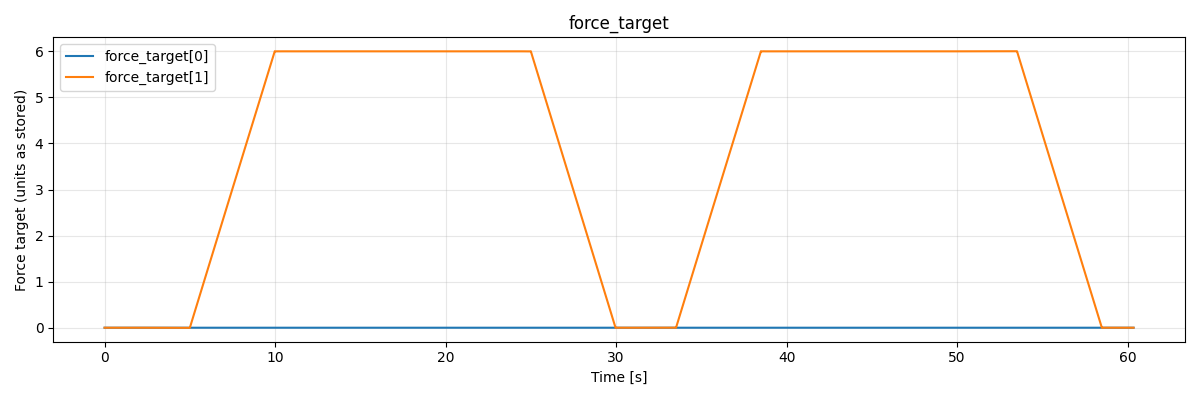

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# --- set your file path ---
path = "/Users/juliahagen/IntMS_EEG/data/preprocessing/P5_combined/90Deg_F2_1_combined.npy"  # <- change me

# --- load ---
d  = np.load(path, allow_pickle=True).item()
t  = np.asarray(d["time_s"])
FT = d.get("force_target", None)

if FT is None:
    raise ValueError("`force_target` not found in the file.")

FT = np.asarray(FT, float)
if FT.ndim == 1:            # make (1, N) for uniform handling
    FT = FT[np.newaxis, :]

# align lengths safely
N = min(t.size, FT.shape[-1])
t  = t[:N]
FT = FT[..., :N]

# --- plot ONLY force_target (each component if multi-row) ---
plt.figure(figsize=(12,4))
for i in range(FT.shape[0]):
    plt.plot(t, FT[i], label=f"force_target[{i}]")
plt.xlabel("Time [s]")
plt.ylabel("Force target (units as stored)")
plt.title("force_target")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Selection


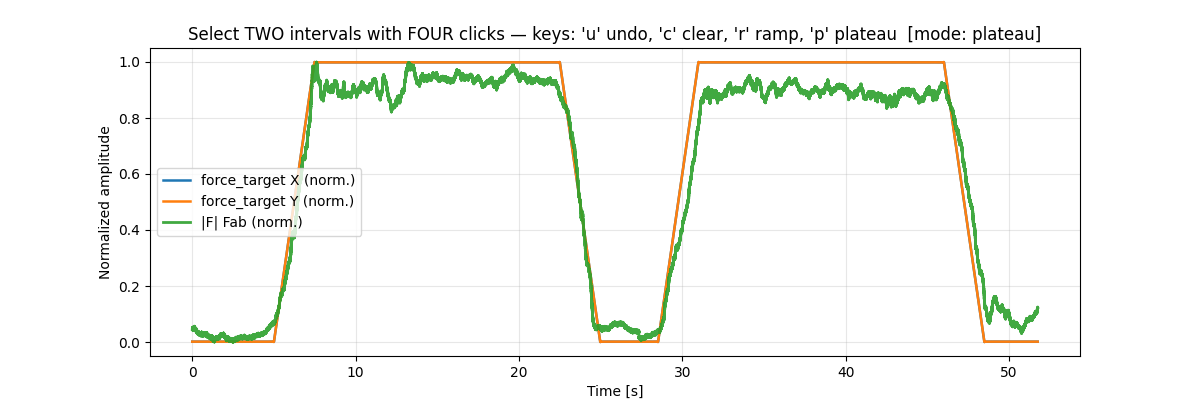

Undid line at x=2.199. Remaining: 0 line(s).
Mode set to: ramp
Selected intervals (ramp):
  [t0,t1] = [5.015, 24.972] s
  [t2,t3] = [28.523, 48.541] s
Samples: [t0,t1]=204362, [t2,t3]=204989, total=409351
✅ Appended selection to 90Deg_F1_1_combined.npy  | kind=ramp  r1=204362  r2=204989  total=409351
Selection complete (4 clicks). Re-run cell to select again if needed.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Load your combined file ---
path = "/Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined/90Deg_F1_1_combined.npy"  # <- change this
data = np.load(path, allow_pickle=True).item()

t   = np.asarray(data["time_s"])
Fab = np.asarray(data["Fab"], float)
FT  = np.asarray(data.get("force_target"), float)  # expected (2, N) or (N, 2)

if FT.ndim == 1:
    FT = FT[np.newaxis, :]
elif FT.shape[0] != 2 and FT.shape[1] == 2:
    FT = FT.T

# --- Align lengths (safety) ---
N = min(t.size, Fab.size, FT.shape[-1])
t   = t[:N]
Fab = Fab[:N]
FT  = FT[:, :N]  # FT[0]=target_x, FT[1]=target_y

# --- Simple min-max normalization per trace (for visibility) ---
def norm01(x):
    x = np.asarray(x, float).ravel()
    lo, hi = np.min(x), np.max(x)
    rng = hi - lo
    return (x - lo) / (rng if rng != 0 else 1.0)

fab_n = norm01(Fab)
tx_n  = norm01(FT[0])
ty_n  = norm01(FT[1])

# ========== NEW: selection mode ('plateau' or 'ramp') ==========
segment_kind = "plateau"  # default; press 'r' to switch, 'p' to switch back

# --- Plot: target X & Y + Fab ---
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t, tx_n, label="force_target X (norm.)", lw=1.8)
ax.plot(t, ty_n, label="force_target Y (norm.)", lw=1.8)
ax.plot(t, fab_n, label="|F| Fab (norm.)", lw=2.0, alpha=0.9)

def _set_title():
    ax.set_title(
        "Select TWO intervals with FOUR clicks — "
        "keys: 'u' undo, 'c' clear, 'r' ramp, 'p' plateau  "
        f"[mode: {segment_kind}]"
    )
_set_title()

ax.set_xlabel("Time [s]")
ax.set_ylabel("Normalized amplitude")
ax.legend()
ax.grid(True, alpha=0.3)

# ---------- minimal saver ----------
def save_selection_to_npy(npy_path, sel, t, kind="plateau"):  # CHANGED: added kind
    npy_path = Path(npy_path)
    d = np.load(npy_path, allow_pickle=True).item()

    idx01 = np.asarray(sel["idx01"], dtype=int)
    idx23 = np.asarray(sel["idx23"], dtype=int)
    fs_est = float(1.0 / np.median(np.diff(t))) if t.size > 1 else None

    entry = {
        "kind": str(kind),  # NEW: tag the cut
        "t0": float(sel["t0"]), "t1": float(sel["t1"]),
        "t2": float(sel["t2"]), "t3": float(sel["t3"]),
        "idx01": idx01, "idx23": idx23,
        "indices_all": np.concatenate([idx01, idx23]),
        "fs_est": fs_est,
    }

    if "cuts" not in d:
        d["cuts"] = []
    d["cuts"].append(entry)

    tmp = npy_path.with_suffix(".tmp.npy")
    np.save(tmp, d, allow_pickle=True)
    tmp.replace(npy_path)
    print(f"✅ Appended selection to {npy_path.name}  | kind={kind}  r1={idx01.size}  r2={idx23.size}  total={idx01.size+idx23.size}")

# --- Simple selection via FOUR clicks -> TWO intervals ---
selected_points = []        # 4 x-values in the order you click
vlines = []                 # vertical line artists (so we can undo)
spans  = []                 # shaded regions

# NEW: colors per mode (so “ramp” looks different)
SPAN_COLORS = {
    "plateau": ("tab:green", "tab:purple"),
    "ramp":    ("tab:orange", "tab:red"),
}

def draw_span(ax, t_start, t_end, color='tab:green', alpha=0.15):
    if t_end < t_start:
        t_start, t_end = t_end, t_start
    return ax.axvspan(t_start, t_end, color=color, alpha=alpha)

def onclick(event):
    if event.inaxes != ax:
        return
    x = float(event.xdata)
    selected_points.append(x)
    vlines.append(ax.axvline(x, color='r', linestyle='--', alpha=0.6))
    fig.canvas.draw()

    c1, c2 = SPAN_COLORS.get(segment_kind, ("tab:green", "tab:purple"))
    # After each pair of clicks, draw a shaded region
    if len(selected_points) == 2:
        spans.append(draw_span(ax, selected_points[0], selected_points[1], color=c1))
        fig.canvas.draw()

    elif len(selected_points) == 4:
        spans.append(draw_span(ax, selected_points[2], selected_points[3], color=c2))
        fig.canvas.draw()

        # Build interval outputs (pairwise: 0–1 and 2–3)
        t0, t1 = sorted(selected_points[:2])
        t2, t3 = sorted(selected_points[2:4])
        print(f"Selected intervals ({segment_kind}):\n  [t0,t1] = [{t0:.3f}, {t1:.3f}] s\n  [t2,t3] = [{t2:.3f}, {t3:.3f}] s")

        # Indices / masks you can reuse later
        idx01 = np.where((t >= t0) & (t <= t1))[0]
        idx23 = np.where((t >= t2) & (t <= t3))[0]
        mask  = np.zeros_like(t, dtype=bool)
        if idx01.size: mask[idx01] = True
        if idx23.size: mask[idx23] = True

        # Expose a handy dict in the notebook for downstream use
        global selection_result
        selection_result = {
            "t0": t0, "t1": t1, "t2": t2, "t3": t3,
            "idx01": idx01, "idx23": idx23, "mask": mask
        }
        print(f"Samples: [t0,t1]={idx01.size}, [t2,t3]={idx23.size}, total={mask.sum()}")

        # Save with the current mode ('plateau' or 'ramp')
        save_selection_to_npy(path, selection_result, t, kind=segment_kind)

        # Stop listening after 4 clicks
        fig.canvas.mpl_disconnect(cid)
        fig.canvas.mpl_disconnect(kid)
        print("Selection complete (4 clicks). Re-run cell to select again if needed.")

def onkey(event):
    global segment_kind
    # 'u' = undo last line; 'c' = clear all; 'r' = ramp; 'p' = plateau
    if event.key == 'u':
        if not selected_points:
            print("No lines to undo.")
            return
        ln = vlines.pop()
        ln.remove()
        x_removed = selected_points.pop()

        if len(selected_points) in (1, 3) and spans:
            sp = spans.pop()
            sp.remove()

        fig.canvas.draw()
        print(f"Undid line at x={x_removed:.3f}. Remaining: {len(selected_points)} line(s).")

    elif event.key == 'c':
        while vlines:
            vlines.pop().remove()
        while spans:
            spans.pop().remove()
        selected_points.clear()
        fig.canvas.draw()
        print("Cleared all lines and spans.")

    elif event.key == 'r':  # NEW: switch to ramp mode
        segment_kind = "ramp"
        _set_title()
        fig.canvas.draw()
        print("Mode set to: ramp")

    elif event.key == 'p':  # NEW: switch to plateau mode
        segment_kind = "plateau"
        _set_title()
        fig.canvas.draw()
        print("Mode set to: plateau")

cid = fig.canvas.mpl_connect('button_press_event', onclick)
kid = fig.canvas.mpl_connect('key_press_event', onkey)
plt.show()


In [8]:
import numpy as np


d = np.load(path, allow_pickle=True).item()

assert "cuts" in d and len(d["cuts"]) > 0, "No cuts saved."
last = d["cuts"][-1]
print("last cut entry keys:", list(last.keys()))
print("times (s):", last["t0"], last["t1"], last["t2"], last["t3"])
print("idx01 len:", len(last["idx01"]), " idx23 len:", len(last["idx23"]))
print("fs_est (Hz):", last["fs_est"])


last cut entry keys: ['kind', 't0', 't1', 't2', 't3', 'idx01', 'idx23', 'indices_all', 'fs_est']
times (s): 5.0148554093188835 24.972072059184484 28.52274250609309 48.541177611939865
idx01 len: 204362  idx23 len: 204989
fs_est (Hz): 10240.000000149012


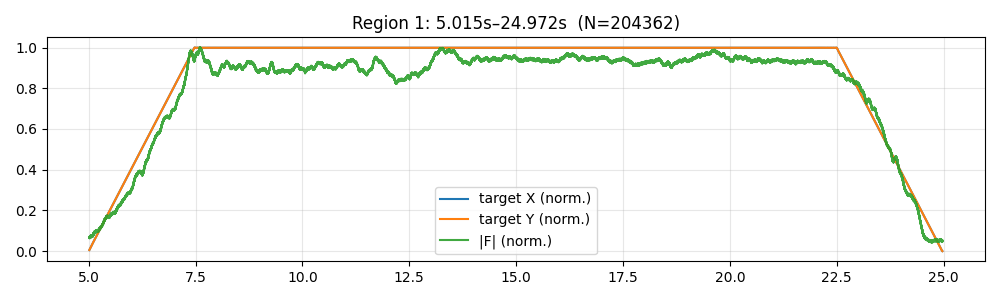

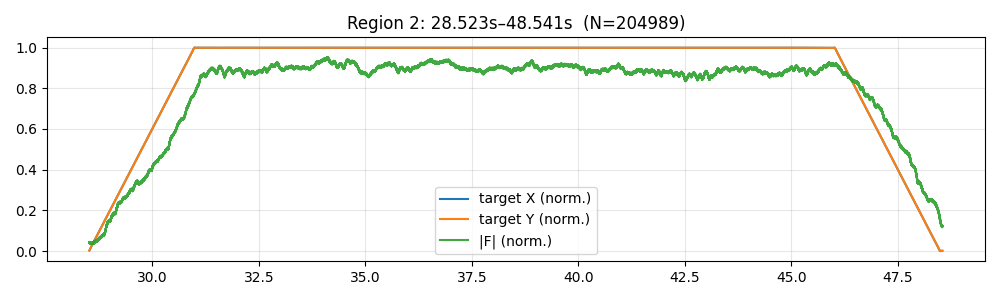

In [9]:
import numpy as np
import matplotlib.pyplot as plt

d = np.load(path, allow_pickle=True).item()
t  = np.asarray(d["time_s"])
Fab = np.asarray(d["Fab"], float)
FT  = np.asarray(d["force_target"], float)
if FT.ndim == 1: FT = FT[np.newaxis, :]
elif FT.shape[0] != 2 and FT.shape[1] == 2: FT = FT.T

cut = d["cuts"][-1]
idx01 = np.asarray(cut["idx01"], dtype=int)
idx23 = np.asarray(cut["idx23"], dtype=int)

def norm01(x):
    x = np.asarray(x, float).ravel()
    lo, hi = np.min(x), np.max(x); rng = hi - lo
    return (x - lo) / (rng if rng != 0 else 1.0)

# normalize for visibility
fab_n = norm01(Fab)
tx_n  = norm01(FT[0])
ty_n  = norm01(FT[1])

# Plot region 1
plt.figure(figsize=(10,3))
plt.plot(t[idx01], tx_n[idx01], label="target X (norm.)")
plt.plot(t[idx01], ty_n[idx01], label="target Y (norm.)")
plt.plot(t[idx01], fab_n[idx01], label="|F| (norm.)", alpha=0.9)
plt.title(f"Region 1: {cut['t0']:.3f}s–{cut['t1']:.3f}s  (N={idx01.size})")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Plot region 2
plt.figure(figsize=(10,3))
plt.plot(t[idx23], tx_n[idx23], label="target X (norm.)")
plt.plot(t[idx23], ty_n[idx23], label="target Y (norm.)")
plt.plot(t[idx23], fab_n[idx23], label="|F| (norm.)", alpha=0.9)
plt.title(f"Region 2: {cut['t2']:.3f}s–{cut['t3']:.3f}s  (N={idx23.size})")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


# Check Preprocessing

In [25]:
import numpy as np
from preprocess import preprocess_plateaus

payload = np.load(path, allow_pickle=True).item()

pp = preprocess_plateaus(
    payload,
    rms_win_samples=100,                              # tune as you like
    modes=("rms_matrix","all_channels","average_channels","single_channel","iterative_addition"),
    single_channel_idx=0,                             # if you need the 'single_channel' mode
    iterative_channels=[0,1,2,3],                     # if you want cumulative sets
    keep_intended_angle=True                          # keep but you can ignore downstream
)

for seg in pp["segments"]:
    print(seg["name"], seg["t_range"], seg["signals"]["t"].shape)
    print("RMS matrix shape:", seg["emg"]["rms_matrix"].shape)
    print("Angle (achieved) shape:", seg["signals"]["angle_achieved"].shape)


plateau01 (10.579006680789494, 25.369637267147024) (151456,)
RMS matrix shape: (151456, 16)
Angle (achieved) shape: (151456,)
plateau23 (40.16026785350455, 54.800739753706154) (149918,)
RMS matrix shape: (149918, 16)
Angle (achieved) shape: (149918,)


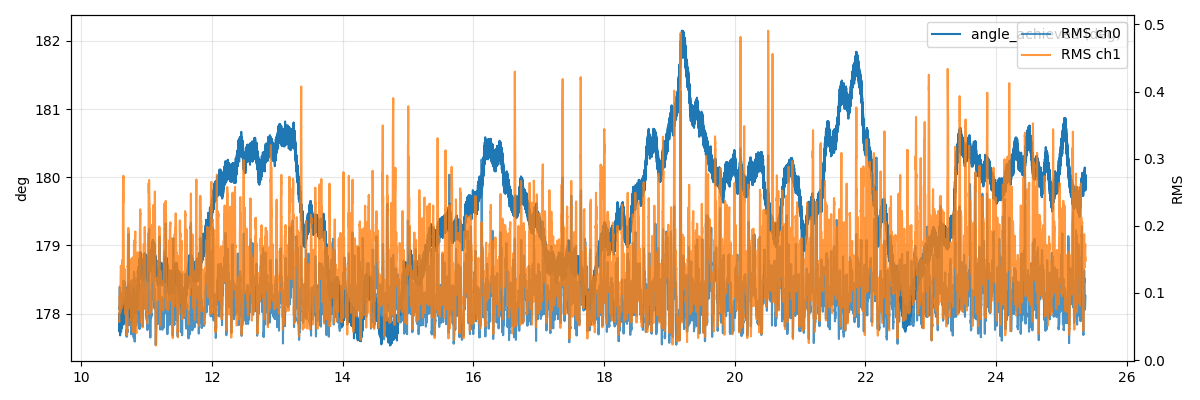

In [26]:
seg = pp["segments"][0]   # plateau01
t   = seg["signals"]["t"]
ang = seg["signals"]["angle_achieved"]
R   = seg["emg"]["rms_matrix"]   # (N,C)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(t, ang, label="angle_achieved (deg)")
plt.ylabel("deg"); plt.legend(); plt.grid(True, alpha=0.3); plt.twinx()
plt.plot(t, R[:,0], label="RMS ch0", alpha=0.8)
plt.plot(t, R[:,1], label="RMS ch1", alpha=0.8)
plt.ylabel("RMS"); plt.legend(); plt.tight_layout(); plt.show()
